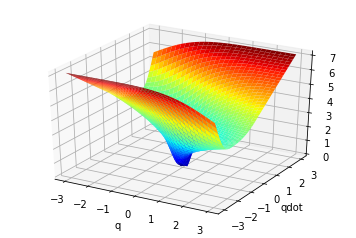

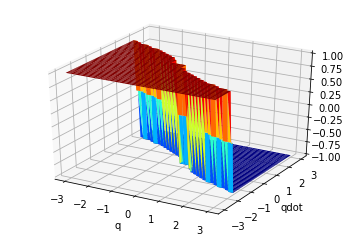

In [3]:
%matplotlib inline
from IPython import display
from __future__ import print_function, absolute_import

import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pydrake.systems.framework import VectorSystem
from pydrake.systems.analysis import Simulator
from pydrake.systems.controllers import (
    DynamicProgrammingOptions, FittedValueIteration)


# TODO(russt): add bindings for LinearSystem and use them instead.
class DoubleIntegrator(VectorSystem):
    def __init__(self):
        # One input, one output, two state variables.
        VectorSystem.__init__(self, 1, 1)
        self._DeclareContinuousState(2)

    # qqdot(t) = u(t)
    def _DoCalcVectorTimeDerivatives(self, context, u, x, xdot):
        xdot[0] = x[1]
        xdot[1] = u

    # y(t) = x(t)
    def _DoCalcVectorOutput(self, context, u, x, y):
        y[:] = x


plant = DoubleIntegrator()
simulator = Simulator(plant)
options = DynamicProgrammingOptions()


def min_time_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    if x.dot(x) < .05:
        return 0.
    return 1.


def quadratic_regulator_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    u = plant.EvalVectorInput(context, 0).CopyToVector()
    return 2*x.dot(x) + 10*u.dot(u)


cost_function = min_time_cost
# cost_function = quadratic_regulator_cost

qbins = np.linspace(-3., 3., 31)
qdotbins = np.linspace(-3., 3., 51)
state_grid = [set(qbins), set(qdotbins)]

input_limit = 1.
input_grid = [set(np.linspace(-input_limit, input_limit, 9))]
timestep = 0.01

[Q, Qdot] = np.meshgrid(qbins, qdotbins)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel("q")
ax.set_ylabel("qdot")

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
ax2.set_xlabel("q")
ax2.set_ylabel("qdot")


def draw(iteration, mesh, cost_to_go, policy):
    # Drawing is slow, don't draw every frame.
    if iteration % 10 != 0:
        return
    plt.title("iteration " + str(iteration))
    J = np.reshape(cost_to_go, Q.shape)
    surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                           cmap=cm.jet)

    Pi = np.reshape(policy, Q.shape)
    surf2 = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1, cmap=cm.jet)

#     if plt.get_backend() != u'template':
#         plt.draw_all()
#         plt.pause(0.00001)
        
    display.display(plt.gcf())
    display.clear_output(wait=True)

#     surf.remove()
#     surf2.remove()


# options.visualization_callback = draw

policy, cost_to_go = FittedValueIteration(simulator, cost_function,
                                          state_grid, input_grid,
                                          timestep, options)

J = np.reshape(cost_to_go, Q.shape)
surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                       cmap=cm.jet)
Pi = np.reshape(policy.get_output_values(), Q.shape)
surf = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1,
                        cmap=cm.jet)

# plt.show()

# TODO: animate the resulting policy.

In [2]:
# plt.close(vis.fig)
# HTML(ani.to_html5_video())

NameError: name 'vis' is not defined

In [9]:
simulator.StepTo(10.)

In [10]:
# Visualize the result as a video.
vis = PendulumVisualizer()
ani = vis.animate(logger, repeat=True)

# plt.show()
# Things added to get visualizations in an ipynb
plt.close(vis.fig)
HTML(ani.to_html5_video())